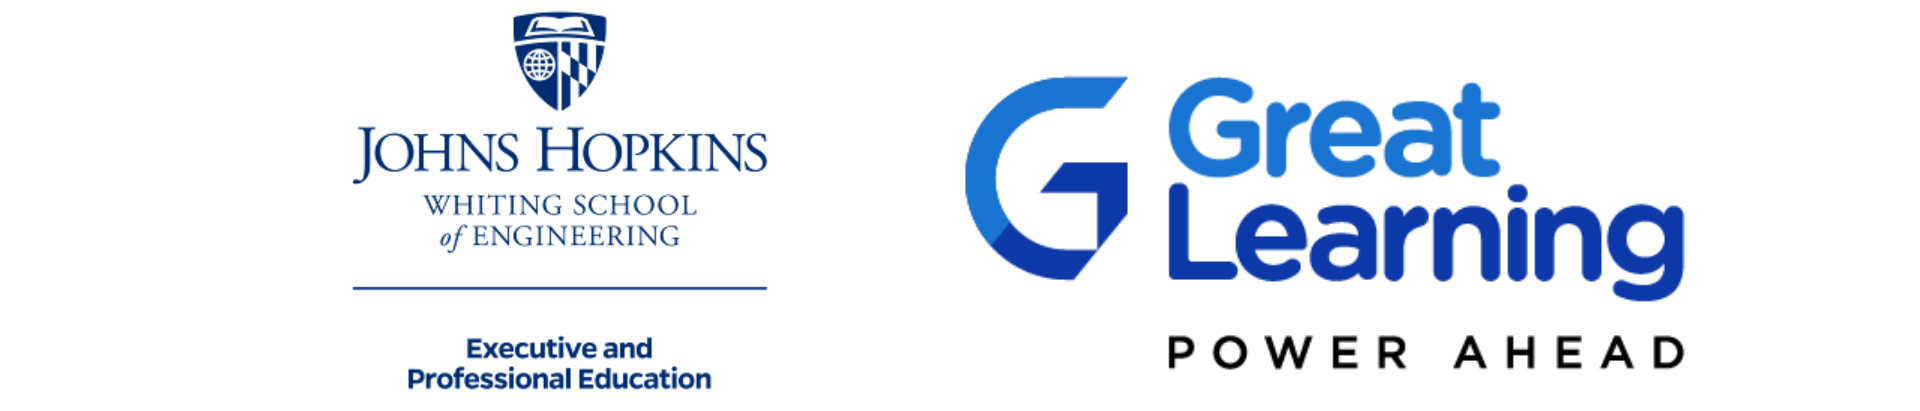

# **Adaptive ReAct vs. Rigid Plan-and-Execute**

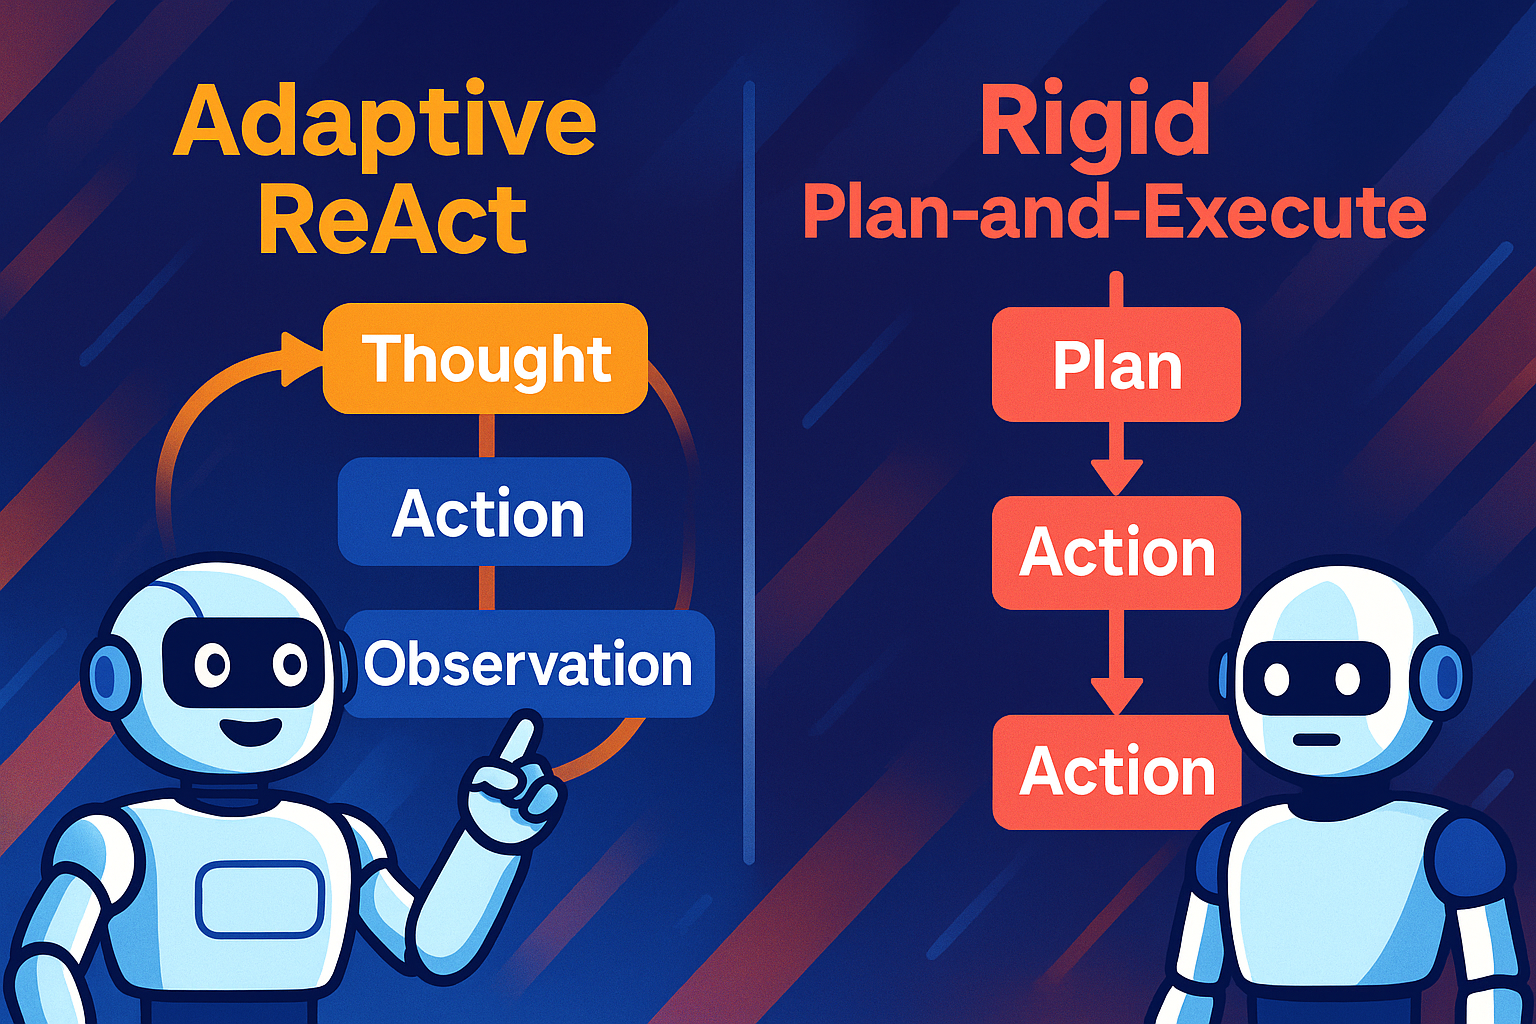

This notebook illustrates the contrast between two problem-solving philosophies for AI agents: a **rigid Plan-and-Execute** approach versus an **adaptive ReAct** approach. Plan-and-Execute commits to a fixed sequence of steps upfront, assuming the world will behave exactly as expected.

However, when uncertainties or ambiguities arise, the rigid plan collapses because it cannot revise its assumptions. In contrast, ReAct operates iteratively — it observes the result of each action and uses that feedback to reason about what to do next. Instead of trying to predict everything in advance, it adapts as the situation evolves. Through this comparison, the notebook demonstrates that in real-world, unpredictable environments, success stems not from having a perfect plan, but from having the ability to adapt and rethink the plan when reality changes.

In [1]:
# -------------------------------
# Install necessary libraries for LangChain and LangGraph
# -------------------------------
!pip install -q langchain>=0.2.0 \
              langchain-community>=0.2.0 \
              langchain-core>=0.2.0 \
              langchain-openai==0.3.24 \
              langgraph

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
# -------------------------------
# Importing necessary libraries
# -------------------------------

from typing import TypedDict, List, Optional, Dict, Any
from dataclasses import dataclass, field
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from langchain_openai import ChatOpenAI
import os
from google.colab import userdata
from datetime import datetime

In [3]:
# -------------------------------
# Decorative Logs
# -------------------------------

# Define helper functions for logging messages with different severity levels
def log_info(message: str):
    print(f"\n🟢 INFO | {datetime.now().strftime('%H:%M:%S')} → {message}")

def log_warning(message: str):
    print(f"\n🟡 WARNING | {datetime.now().strftime('%H:%M:%S')} → ⚠️  {message}")

def log_error(message: str):
    print(f"\n🔴 ERROR | {datetime.now().strftime('%H:%M:%S')} → ❌  {message}")

def log_step(title: str):
    print("\n" + "═" * 60)
    print(f"🔷 {title.upper()}")
    print("═" * 60)

In [4]:
# -------------------------------
# LLM
# -------------------------------

# Load the OpenAI API key and Base URL
os.environ['OPENAI_API_KEY'] = userdata.get('GL_OpenAI')
os.environ["OPENAI_BASE_URL"] = "https://aibe.mygreatlearning.com/openai/v1"

# Initialize the ChatOpenAI language model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [5]:
# -------------------------------
# Simulating Sample Database
# -------------------------------

CONTACTS_DB = {
"John Smith": {"email": "john.smith@example.com", "department": "Research & Development"},
"John Doe": {"email": "john.doe@example.com", "department": "Human Resources"},
"Alice": {"email": "alice@example.com", "department": "International Sales"},
}

# **Rigid Plan-and-Execute**

**What it is:**

Plan-and-Execute asks the LLM to create a full plan up front before doing anything.
The LLM predicts the entire sequence of tool calls and then executes them blindly.

**How it works:**
1. Generate a full plan.
2. Execute steps sequentially — no rethinking, no adjustments.

**In our scenario Task:** “Send an email regarding the budget meeting.”

```
 ┌───────────┐      ┌──────────────┐      ┌────────────┐
 |  PLAN     | ---> |  CONTACTS    | ---> | EMAIL_SEND |
 └───────────┘      └──────────────┘      └────────────┘
                        |
                        |
                        v
               ⚠️ Error (Ambiguity)
                (Graph ends, no retry)
```


In [6]:
# -------------------------------
# State
# -------------------------------
class RigidAgentState(TypedDict):
    user: str                 # Name of the recipent to mail
    steps: List[Any]          # Example: [("contacts", "John"), ("email_send", ...)]

    contact: str | None       # Result of contacts("John")
    contact_result: dict      # Result in case of multiple contacts
    email_result: str | None  # Result of email_send(...)

In [7]:
# -------------------------------
# Nodes
# As this is Rigid planning, steps are already decided
# Step 1 - Get the contact name from the `user`
# Step 2 - Send the email to the `user`
# -------------------------------
def plan_node(RigidAgentState):
    log_step("Running plan_node")

    log_info(f"Planning next actions based on user request → '{RigidAgentState['user']}'")

    plan = {
        "steps": [
            ("contacts", RigidAgentState["user"]),     # step 1
            ("email_send", RigidAgentState["user"])    # step 2
        ]
    }

    log_info(f"Generated execution plan → {plan['steps']}")

    return plan

In [8]:
def contacts_tool(query_name: str):
    """Return a single contact or an ambiguous result with logs."""
    log_step("Running contacts_tool")
    log_info(f"Searching DB for: '{query_name}'")

    matches = [name for name in CONTACTS_DB.keys() if query_name.lower() in name.lower()]

    if len(matches) == 1:
        name = matches[0]
        log_info(f"✅ Match found → {name}")
        return {"success": True, "contact": { "name": name, **CONTACTS_DB[name] }}

    elif len(matches) > 1:
        log_warning(f"Multiple matches found → {matches}")
        return {"success": False, "error": f"AMBIGUOUS: {matches}"}

    else:
        log_error("CONTACT_NOT_FOUND → No matching name in DB")
        return {"success": False, "error": "CONTACT_NOT_FOUND"}


def contacts_node(RigidAgentState):
    log_step("Running contacts_node")

    step_action, step_arg = RigidAgentState["steps"][0]
    log_info(f"Step action: {step_action} | Looking for contact: {step_arg}")

    result = contacts_tool(step_arg)

    log_info(f"Saving result to state → {result}")
    RigidAgentState["contact_result"] = result

    return RigidAgentState


In [9]:
# -------------------------------
# Simulation of sending an email
# -------------------------------

def email_send_tool(contact: dict, subject: str, body: str):
    """Simulate sending an email."""
    log_info(f"📧 Sending email to {contact['name']} ({contact['email']})")
    return f"✅ Email sent to {contact['name']} ({contact['email']}) | subject='{subject}'"


def email_node(RigidAgentState):
    log_step("Running email_node")

    result = RigidAgentState["contact_result"]  # Output from contacts_node()
    log_info(f"Previous step result → {result}")

    # If contact lookup failed or was ambiguous → fail execution
    if not result["success"]:
        error_msg = f"❌ Cannot send email: {result['error']}"
        log_error(error_msg)
        RigidAgentState["email_result"] = error_msg
        return RigidAgentState

    # Extract contact information
    contact = result["contact"]
    log_info(f"Resolved contact → {contact['name']} ({contact['email']})")

    # Hardcoded email details (since this scenario is about plan execution)
    subject = "Budget Meeting"
    body = f"""
    Hi {contact['name']},
    I hope you're doing well. We need to discuss the budget for the upcoming project.
    Please let me know when you’re available for a quick call or meeting.

    Best regards,
    Your Name
    """


    log_info(f"Preparing email...\n   • Subject: {subject}\n   • Body: {body}")

    # Send email using the tool
    final = email_send_tool(contact, subject, body)

    log_info("✅ Email operation completed successfully.")
    RigidAgentState["email_result"] = final

    return RigidAgentState


In [10]:
# -------------------------------
# Rigid Workflow
# -------------------------------

rigid_workflow = StateGraph(RigidAgentState)

rigid_workflow.add_node("planner", plan_node)
rigid_workflow.add_node("contacts", contacts_node)
rigid_workflow.add_node("email", email_node)

rigid_workflow.add_edge("planner", "contacts")
rigid_workflow.add_edge("contacts", "email")

rigid_workflow.set_entry_point("planner")
rigid_workflow.set_finish_point("email")

rigid_app = rigid_workflow.compile()


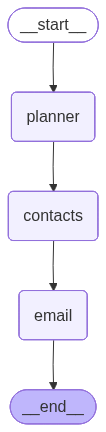

In [11]:
rigid_app

## Test cases

In [29]:
# -------------------------------
# Test - Pass
# -------------------------------
initail_state = {"user":"Alice"}
output_state = rigid_app.invoke(initail_state)
output_state


════════════════════════════════════════════════════════════
🔷 RUNNING PLAN_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:57:53 → Planning next actions based on user request → 'Alice'

🟢 INFO | 18:57:53 → Generated execution plan → [('contacts', 'Alice'), ('email_send', 'Alice')]

════════════════════════════════════════════════════════════
🔷 RUNNING CONTACTS_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:57:53 → Step action: contacts | Looking for contact: Alice

════════════════════════════════════════════════════════════
🔷 RUNNING CONTACTS_TOOL
════════════════════════════════════════════════════════════

🟢 INFO | 18:57:53 → Searching DB for: 'Alice'

🟢 INFO | 18:57:53 → ✅ Match found → Alice

🟢 INFO | 18:57:53 → Saving result to state → {'success': True, 'contact': {'name': 'Alice', 'email': 'alice@example.com', 'department': 'International Sales'}}

════════════════════════════════════════════════════════════
🔷 RUNN

{'user': 'Alice',
 'steps': [('contacts', 'Alice'), ('email_send', 'Alice')],
 'contact_result': {'success': True,
  'contact': {'name': 'Alice',
   'email': 'alice@example.com',
   'department': 'International Sales'}},
 'email_result': "✅ Email sent to Alice (alice@example.com) | subject='Budget Meeting'"}

In [13]:
# -------------------------------
# Test - Fail
# -------------------------------
initail_state = {"user":"John"}
output_state = rigid_app.invoke(initail_state)
output_state


════════════════════════════════════════════════════════════
🔷 RUNNING PLAN_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:55:36 → Planning next actions based on user request → 'John'

🟢 INFO | 18:55:36 → Generated execution plan → [('contacts', 'John'), ('email_send', 'John')]

════════════════════════════════════════════════════════════
🔷 RUNNING CONTACTS_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:55:36 → Step action: contacts | Looking for contact: John

════════════════════════════════════════════════════════════
🔷 RUNNING CONTACTS_TOOL
════════════════════════════════════════════════════════════

🟢 INFO | 18:55:36 → Searching DB for: 'John'

🟡 WARNING | 18:55:36 → ⚠️  Multiple matches found → ['John Smith', 'John Doe']

🟢 INFO | 18:55:36 → Saving result to state → {'success': False, 'error': "AMBIGUOUS: ['John Smith', 'John Doe']"}

════════════════════════════════════════════════════════════
🔷 RUNNING EMAIL_NODE

{'user': 'John',
 'steps': [('contacts', 'John'), ('email_send', 'John')],
 'contact_result': {'success': False,
  'error': "AMBIGUOUS: ['John Smith', 'John Doe']"},
 'email_result': "❌ Cannot send email: AMBIGUOUS: ['John Smith', 'John Doe']"}

# **Adaptive ReAct**

**What it is:**

ReAct executes tasks in small loops:
**Think → Act → Observe → Adjust → Continue**

Instead of planning everything up front, the agent takes the next best action based on the latest observation..

**How it works:**
1. Think (decide what to do next)
2. Act (execute a tool)
3. Observe (read tool output)
4. Repeat until done

**In our scenario Task:** “Send an email to John”

While writing an email to John:

```
Multiple contacts found: John Smith, John Doe
```

**ReAct responds with a new Thought:**

> “Ambiguity detected. I should refine the search — maybe by role or department.”

It then chooses a new tool call to disambiguate, e.g.:
```
Which contact (John) should I refer to ? The one from Research & Development or Human Resources department ?
```
Finally, the correct contact is identified by analyzing the department and query context and the email is sent successfully.

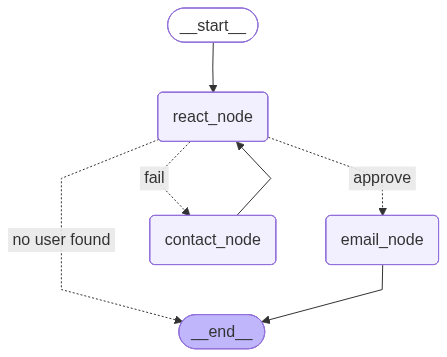

In [14]:
# -------------------------------
# Structure Output to get the required field/data from the LLM
# -------------------------------
class relevant_candidate(BaseModel):
    user_name: str = Field(description="Find the most relevant employee to send a mail based on user message.")

structured_model = llm.with_structured_output(relevant_candidate)

In [15]:
# -------------------------------
# State
# -------------------------------

class ReactAgentState(TypedDict):
    flag: Optional[str] | None
    counter: int
    user_name: str | None
    details: dict | None
    error: str | None
    message: str | None
    email_content: str | None

In [16]:
# -------------------------------
# Nodes
# -------------------------------

def react_node(state: ReactAgentState):
    log_step("Running react_node")
    log_info(f"Checking if multiple entries exist for: {state['user_name']}")

    matches = [name for name in CONTACTS_DB.keys() if state["user_name"].lower() in name.lower()]

    if len(matches) == 1:
        name = matches[0]
        log_info(f"✅ Match Found → {name}")
        return {"details": { "name": name, **CONTACTS_DB[name] }, "flag": "approve"}

    elif len(matches) > 1:
        log_warning(f"Ambiguity detected → Matches: {matches}")
        return {"error": f"AMBIGUOUS: {matches}", "flag": "fail"}

    else:
        log_error("No contact found in DB ❌")
        return {"error": "CONTACT_NOT_FOUND", "flag": "END"}


In [17]:
# -------------------------------
#  Using LLM to resolve the ambiguity
# -------------------------------

def contact_node(state: ReactAgentState):
    log_step("Running contact_node (Retry logic)")
    log_warning(f"Trying to resolve ambiguity... Attempt #{state['counter']}")

    candidate_fetch_prompt = f"""
                              You are an expert in contextual reasoning and corporate organizational analysis.
                              You deeply understand how companies structure their teams, roles, and departments,
                              and how responsibilities are distributed across similar job titles.

                              Your task is to analyze the provided user request and the employee database.
                              From the database, identify the single most relevant person to whom an email should be sent
                              to accomplish the described task — even if multiple people have similar names or roles.

                              Follow these principles:
                              - Prioritize **exact or close matches** between the user’s described role, responsibility, or department and the database entries.
                              - Consider the **hierarchical level** (e.g., "Manager" > "Associate" if the task implies decision-making).
                              - Use contextual understanding — for instance, if the message asks "approve the budget", prefer finance or senior manager.
                              - If multiple candidates are similar, choose the **most likely authoritative or contextually relevant** one.
                              - Do **not** fabricate names or roles — only select from the given database.
                              - Output should only contain than name and nothing else.
                              ---

                              ### TASK / USER MESSAGE:
                              {state['message']}

                              ### EMPLOYEE DATABASE:
                              {CONTACTS_DB}

                              ### SAMPLE OUTPUT:
                              "John Carter"

                              ---

                              ### RESPONSE:
                              """

    state['user_name'] = structured_model.invoke(candidate_fetch_prompt).user_name
    log_info(f"Selected most relevant candidate → ✅ {state['user_name']}")
    return state


In [18]:
# -------------------------------
# Simulation of sending an email
# -------------------------------

def email_node(state: ReactAgentState):
    log_step("Running email_node")
    log_info(f"Sending email to: {state['details'].get('email')}")

    prompt= f"""Write a professional email to {state["details"].get("email")}.
              The topic of the email is {state["message"]}.
              Maintain a formal tone and. Provide a clear subject line and closing.
              Provide the 3 things of the Email:

              **To:** <Email of the recipient>
              **Subject:** <Subject of the email>
              **Body:** <Body of the email and closing>
              """
    state["email_content"] = llm.invoke(prompt).content

    log_info("📧 Email successfully generated.")
    return state


In [23]:
# -------------------------------
# ReAct Workflow
# -------------------------------

react_workflow = StateGraph(ReactAgentState)

react_workflow.add_node("react_node", react_node)
react_workflow.add_node("email_node", email_node)
react_workflow.add_node("contact_node", contact_node)

react_workflow.add_edge(START,"react_node")


# Conditional routing from react_node
react_workflow.add_conditional_edges(
    "react_node",
    lambda state: state["flag"],  # must return "approve" or "fail"
    {
        "approve": "email_node",     # 3) email -> end (set below)
        "fail": "contact_node",      # 4) fail -> contact_node
        "END": END,
    },
)

# contact_node loops back to react_node
react_workflow.add_edge("contact_node", "react_node")

# email ends workflow
react_workflow.add_edge("email_node", END)

# Compile
react_app = react_workflow.compile()

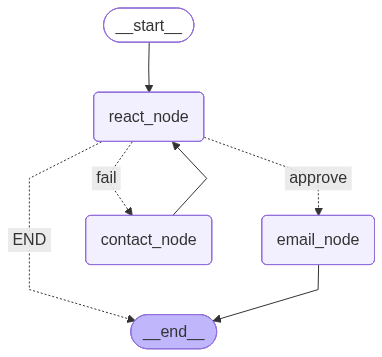

In [24]:
react_app

## Test Cases

In [25]:
# -------------------------------
# Test - Pass
# -------------------------------
inital_state = {"user_name":"Alice",
                "counter":1,
                "message":"Please write an email to Alice requesting confirmation regarding the latest candidate hires."}
output = react_app.invoke(inital_state)
output


════════════════════════════════════════════════════════════
🔷 RUNNING REACT_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:10 → Checking if multiple entries exist for: Alice

🟢 INFO | 18:56:10 → ✅ Match Found → Alice

════════════════════════════════════════════════════════════
🔷 RUNNING EMAIL_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:10 → Sending email to: alice@example.com

🟢 INFO | 18:56:13 → 📧 Email successfully generated.


{'flag': 'approve',
 'counter': 1,
 'user_name': 'Alice',
 'details': {'name': 'Alice',
  'email': 'alice@example.com',
  'department': 'International Sales'},
 'message': 'Please write an email to Alice requesting confirmation regarding the latest candidate hires.',
 'email_content': '**To:** alice@example.com  \n**Subject:** Request for Confirmation on Latest Candidate Hires  \n\n**Body:**  \nDear Alice,  \n\nI hope this message finds you well. I am writing to kindly request your confirmation regarding the latest candidate hires. It is important for us to ensure that all details are accurate and up to date as we move forward with the onboarding process.  \n\nCould you please provide an update at your earliest convenience? Your assistance in this matter is greatly appreciated.  \n\nThank you for your attention to this request.  \n\nBest regards,  \n[Your Name]  \n[Your Position]  \n[Your Company]  \n[Your Contact Information]  '}

In [26]:
# -------------------------------
# Test - No contact name found
# -------------------------------
inital_state = {"user_name":"Robin Hood",
                "counter":1,
                "message":"Please write an email to John requesting confirmation regarding the latest candidate hires."}
output = react_app.invoke(inital_state)
output


════════════════════════════════════════════════════════════
🔷 RUNNING REACT_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:13 → Checking if multiple entries exist for: Robin Hood

🔴 ERROR | 18:56:13 → ❌  No contact found in DB ❌


{'flag': 'END',
 'counter': 1,
 'user_name': 'Robin Hood',
 'error': 'CONTACT_NOT_FOUND',
 'message': 'Please write an email to John requesting confirmation regarding the latest candidate hires.'}

In [27]:
# -------------------------------
# Test - Fail an Retry
# -------------------------------

inital_state = {"user_name":"John",
                "counter":1,
                "message":"Please write an email to John requesting confirmation regarding the latest candidate hires."}

output = react_app.invoke(inital_state)
output


════════════════════════════════════════════════════════════
🔷 RUNNING REACT_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:13 → Checking if multiple entries exist for: John

🟡 WARNING | 18:56:13 → ⚠️  Ambiguity detected → Matches: ['John Smith', 'John Doe']

════════════════════════════════════════════════════════════
🔷 RUNNING CONTACT_NODE (RETRY LOGIC)
════════════════════════════════════════════════════════════

🟡 WARNING | 18:56:13 → ⚠️  Trying to resolve ambiguity... Attempt #1

🟢 INFO | 18:56:14 → Selected most relevant candidate → ✅ John Doe

════════════════════════════════════════════════════════════
🔷 RUNNING REACT_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:14 → Checking if multiple entries exist for: John Doe

🟢 INFO | 18:56:14 → ✅ Match Found → John Doe

════════════════════════════════════════════════════════════
🔷 RUNNING EMAIL_NODE
════════════════════════════════════════════════════════════

🟢 I

{'flag': 'approve',
 'counter': 1,
 'user_name': 'John Doe',
 'details': {'name': 'John Doe',
  'email': 'john.doe@example.com',
  'department': 'Human Resources'},
 'error': "AMBIGUOUS: ['John Smith', 'John Doe']",
 'message': 'Please write an email to John requesting confirmation regarding the latest candidate hires.',
 'email_content': '**To:** john.doe@example.com  \n**Subject:** Request for Confirmation on Latest Candidate Hires  \n\n**Body:**  \n\nDear John,  \n\nI hope this message finds you well. I am writing to request your confirmation regarding the latest candidate hires that were discussed in our recent meetings. It is important for us to ensure that all details are accurate and that we are aligned on the final selections.  \n\nCould you please provide your confirmation at your earliest convenience? Your input is greatly appreciated as we move forward with the onboarding process.  \n\nThank you for your attention to this matter.  \n\nBest regards,  \n[Your Name]  \n[Your Po

In [28]:
# -------------------------------
# Test - Fail an Retry
# Calling John, with different message
# -------------------------------

inital_state = {"user_name":"John",
                "counter":1,
                "message":"Please write an email to John requesting an update on the latest updates on a new product"}

output = react_app.invoke(inital_state)
output


════════════════════════════════════════════════════════════
🔷 RUNNING REACT_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:17 → Checking if multiple entries exist for: John

🟡 WARNING | 18:56:17 → ⚠️  Ambiguity detected → Matches: ['John Smith', 'John Doe']

════════════════════════════════════════════════════════════
🔷 RUNNING CONTACT_NODE (RETRY LOGIC)
════════════════════════════════════════════════════════════

🟡 WARNING | 18:56:17 → ⚠️  Trying to resolve ambiguity... Attempt #1

🟢 INFO | 18:56:18 → Selected most relevant candidate → ✅ John Smith

════════════════════════════════════════════════════════════
🔷 RUNNING REACT_NODE
════════════════════════════════════════════════════════════

🟢 INFO | 18:56:18 → Checking if multiple entries exist for: John Smith

🟢 INFO | 18:56:18 → ✅ Match Found → John Smith

════════════════════════════════════════════════════════════
🔷 RUNNING EMAIL_NODE
═══════════════════════════════════════════════════════════

{'flag': 'approve',
 'counter': 1,
 'user_name': 'John Smith',
 'details': {'name': 'John Smith',
  'email': 'john.smith@example.com',
  'department': 'Research & Development'},
 'error': "AMBIGUOUS: ['John Smith', 'John Doe']",
 'message': 'Please write an email to John requesting an update on the latest updates on a new product',
 'email_content': '**To:** john.smith@example.com  \n**Subject:** Request for Update on New Product Development  \n\n**Body:**  \nDear John,  \n\nI hope this message finds you well. I am writing to kindly request an update on the latest developments regarding the new product we have been working on. As we approach the next phase of our project, it would be beneficial to understand the current status and any key milestones that have been achieved.  \n\nYour insights will greatly assist in our planning and coordination efforts. Thank you for your attention to this matter, and I look forward to your prompt response.  \n\nBest regards,  \n[Your Name]  \n[Your Po

# **Conclusion**

1. When ambiguity appears, a static plan collapses.
2. ReAct evolves with the situation, turning unexpected outcomes into guidance.
3. Real-world automation favors agents that can think, not just execute.